<a href="https://colab.research.google.com/github/xeromark/TareasIA/blob/main/Tareas%203/TareaIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tarea 3 de IA de Omar Marca y Luis Reyes. Github: https://github.com/xeromark/TareasIA



El dataset utilizado para la parte 2 se trata sobre estadisticas de personas cuyos ingresos superan los $50,000 dolares al año.

---

# Pregunta 1

## Reproduzca el tutorial implementando la arquitectura. Comente paso a paso lo que se hace en sus propias palabras.

Las neuronas KAN utilizan funciones de borde no lineales para transformar las entradas con el objetivo de que se pueda procesar la información con menos recursos computacionales y realizar cálculos más complejos.



Por otra parte, en MLP las entradas se transforman mediante funciones de activación lineales o no lineales para introducir no linealidades en el modelo, es decir, que el modelo sea capaz de representar relaciones complejas entre las variables de entrada y salida que no pueden ser descritas por una simple relación lineal.




### Neurona

Para poder utilizar MLP y KAN, se establecen métodos en python para proporcionar una estructura versátil que pueda acomodar tanto las Redes de Kolmogorov-Arnold (KAN) como los Perceptrones Multicapa (MLP). Es por ello que se definen los siguientes métodos del funcionamiento de una neurona:

In [ ]:
import numpy as np

class Neuron:

    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  # n. inputs
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  # input variable
        self.xmid = None  # edge variables
        self.xout = None  # output variable
        self.dxout_dxmid = None  # derivative d xout / d xmid: (n_in, )
        self.dxout_dbias = None  # derivative d xout / d bias
        self.dxmid_dw = None  # derivative d xmid / d w: (n_in, n_par_per_edge)
        self.dxmid_dxin = None  # derivative d xmid / d xin
        self.dxout_dxin = None  # (composite) derivative d xout / d xin
        self.dxout_dw = None  # (composite) derivative d xout / d w
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  # (composite) derivative d loss / d w
        self.dloss_dbias = 0  # (composite) derivative d loss / d bias

    def __call__(self, xin):
        # forward pass: compute neuron's output
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()

        # compute internal derivatives
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()

        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)

        # compute external derivatives
        self.get_dxout_dxin()
        self.get_dxout_dw()

        return self.xout

    def get_xmid(self):
        # compute self.xmid
        pass

    def get_xout(self):
        # compute self.xout
        pass

    def get_dxout_dxmid(self):
        # compute self.dxout_dxmid
        pass

    def get_dxout_dbias(self):
        # compute self.dxout_dbias
        pass  #self.dxout_dbias = 0  # by default

    def get_dxmid_dw(self):
        # compute self.dxmid_dw
        pass

    def get_dxmid_dxin(self):
        # compute self.dxmid_dxin
        pass

    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin

    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw

    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout

    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias

### Función de activación

Para poder facilitar el uso de las funciones de Activación, se definen los siguientes métodos:

In [ ]:
import math

def relu(x, get_derivative=False):
    return x * (x > 0) if not get_derivative else 1.0 * (x >= 0)

def tanh_act(x, get_derivative=False):
    if not get_derivative:
        return math.tanh(x)
    return 1 - math.tanh(x) ** 2

def sigmoid_act(x, get_derivative=False):
    if not get_derivative:
        return 1 / (1 + math.exp(-x))
    return sigmoid_act(x) * (1 - sigmoid_act(x))

### MLP Métodos

Luego se define la clase NeuronNN que implementa los métodos de MLP. Esta clase se inicializa con el número de entradas **(n_in)**, un rango que es opcional para los pesos **(weights_range)** y una función de activación **(activation)**. Por defecto, la función de activación es **ReLU**.

In [ ]:
class NeuronNN(Neuron):

    def __init__(self, n_in, weights_range=None, activation=relu):
        super().__init__(n_in, n_weights_per_edge=1, weights_range=weights_range)
        self.activation = activation
        self.activation_input = None

    def get_xmid(self):
        self.xmid = self.weights[:, 0] * self.xin

    def get_xout(self):
        self.activation_input = sum(self.xmid.flatten()) + self.bias
        self.xout = self.activation(self.activation_input, get_derivative=False)

    def get_dxout_dxmid(self):
        self.dxout_dxmid = self.activation(self.activation_input, get_derivative=True) * np.ones(self.n_in)

    def get_dxout_dbias(self):
        self.dxout_dbias = self.activation(self.activation_input, get_derivative=True)

    def get_dxmid_dw(self):
        self.dxmid_dw = np.reshape(self.xin, (-1, 1))

    def get_dxmid_dxin(self):
        self.dxmid_dxin = self.weights.flatten()

Luego, se define la función **get_bsplines()** para genera un conjunto de funciones borde no lineales (B-splines) y sus derivadas asociadas que serán utilizadas en la posterior implementación de neuronas KAN.

In [ ]:
from scipy.interpolate import BSpline

def get_bsplines(x_bounds, n_fun, degree=3, **kwargs):
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun, edge_fun_der = {}, {}

    # SiLU bias function
    edge_fun[0] = lambda x: x / (1 + np.exp(-x))
    edge_fun_der[0] = lambda x: (1 + np.exp(-x) + x * np.exp(-x)) / np.power((1 + np.exp(-x)), 2)

    # B-splines
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]
    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)
        edge_fun_der[ind_spline + 1] = edge_fun[ind_spline + 1].derivative()
    return edge_fun, edge_fun_der

### Clase KAN

Ya teniendo todas las funciones y métodos de python necesarios para armar la clase para KAN en python, se obtiene lo siguiente:

In [ ]:
class NeuronKAN(Neuron):

    def __init__(self, n_in, n_weights_per_edge, x_bounds, weights_range=None, get_edge_fun=get_bsplines, **kwargs):
        self.x_bounds = x_bounds
        super().__init__(n_in, n_weights_per_edge=n_weights_per_edge, weights_range=weights_range)
        self.edge_fun, self.edge_fun_der = get_edge_fun(self.x_bounds, self.n_weights_per_edge, **kwargs)

    def get_xmid(self):
        # apply edge functions
        self.phi_x_mat = np.array([self.edge_fun[b](self.xin) for b in self.edge_fun]).T
        self.phi_x_mat[np.isnan(self.phi_x_mat)] = 0
        self.xmid = (self.weights * self.phi_x_mat).sum(axis=1)

    def get_xout(self):
        # note: node function <- tanh to avoid any update of spline grids
        self.xout = tanh_act(sum(self.xmid.flatten()), get_derivative=False)

    def get_dxout_dxmid(self):
        self.dxout_dxmid = tanh_act(sum(self.xmid.flatten()), get_derivative=True) * np.ones(self.n_in)

    def get_dxmid_dw(self):
        self.dxmid_dw = self.phi_x_mat

    def get_dxmid_dxin(self):
        phi_x_der_mat = np.array([self.edge_fun_der[b](self.xin) if self.edge_fun[b](self.xin) is not None else 0
                                  for b in self.edge_fun_der]).T  # shape (n_in, n_weights_per_edge)
        phi_x_der_mat[np.isnan(phi_x_der_mat)] = 0
        self.dxmid_dxin = (self.weights * phi_x_der_mat).sum(axis=1)

    def get_dxout_dbias(self):
        # no bias in KAN!
        self.dxout_dbias = 0

### 2. Capas totalmente conectadas


Una capa totalmente conectada es una colección de neuronas donde el mismo vector de entrada se alimenta a todas las neuronas de la capa. La salida de la capa es un vector que contiene las salidas de todas las neuronas. A continuación se presenta su implementación en python:

In [ ]:
class FullyConnectedLayer:

    def __init__(self, n_in, n_out, neuron_class=NeuronNN, **kwargs):
        self.n_in, self.n_out = n_in, n_out
        self.neurons = [neuron_class(n_in) if (kwargs == {}) else neuron_class(n_in, **kwargs) for _ in range(n_out)]
        self.xin = None  # input, shape (n_in,)
        self.xout = None  # output, shape (n_out,)
        self.dloss_dxin = None  # d loss / d xin, shape (n_in,)
        self.zero_grad()

    def __call__(self, xin):
        # forward pass
        self.xin = xin
        self.xout = np.array([nn(self.xin) for nn in self.neurons])
        return self.xout

    def zero_grad(self, which=None):
        # reset gradients to zero
        if which is None:
            which = ['xin', 'weights', 'bias']
        for w in which:
            if w == 'xin':  # reset layer's d loss / d xin
                self.dloss_dxin = np.zeros(self.n_in)
            elif w == 'weights':  # reset d loss / dw to zero for every neuron
                for nn in self.neurons:
                    nn.dloss_dw = np.zeros((self.n_in, self.neurons[0].n_weights_per_edge))
            elif w == 'bias':  # reset d loss / db to zero for every neuron
                for nn in self.neurons:
                    nn.dloss_dbias = 0
            else:
                raise ValueError('input \'which\' value not recognized')

    def update_grad(self, dloss_dxout):
        # update gradients by chain rule
        for ii, dloss_dxout_tmp in enumerate(dloss_dxout):
            # update layer's d loss / d xin via chain rule
            # note: account for all possible xin -> xout -> loss paths!
            self.dloss_dxin += self.neurons[ii].dxout_dxin * dloss_dxout_tmp
            # update neuron's d loss / dw and d loss / d bias
            self.neurons[ii].update_dloss_dw_dbias(dloss_dxout_tmp)
        return self.dloss_dxin

### 3. Función de pérdida

Para saber que tan bueno es el modelo, se deben evalúa qué tan cerca se alinean las predicciones de la red respecto a la salida con la que se está entrenando **(y_train)** con una función de pérdida. Es por ello que a continuación se presenta la implementación en python:

In [ ]:
class Loss:

    def __init__(self, n_in):
        self.n_in = n_in
        self.y, self.dloss_dy, self.loss, self.y_train = None, None, None, None

    def __call__(self, y, y_train):
        # y: output of network
        # y_train: ground truth
        self.y, self.y_train = np.array(y), y_train
        self.get_loss()
        self.get_dloss_dy()
        return self.loss

    def get_loss(self):
        # compute loss l(y, y_train)
        pass

    def get_dloss_dy(self):
        # compute gradient of loss wrt y
        pass


class SquaredLoss(Loss):

    def get_loss(self):
        # compute loss l(xin, y)
        self.loss = np.mean(np.power(self.y - self.y_train, 2))

    def get_dloss_dy(self):
        # compute gradient of loss wrt xin
        self.dloss_dy = 2 * (self.y - self.y_train) / self.n_in


class CrossEntropyLoss(Loss):

    def get_loss(self):
        # compute loss l(xin, y)
        self.loss = - np.log(np.exp(self.y[self.y_train[0]]) / sum(np.exp(self.y)))

    def get_dloss_dy(self):
        # compute gradient of loss wrt xin
        self.dloss_dy = np.exp(self.y) / sum(np.exp(self.y))
        self.dloss_dy[self.y_train] -= 1

### 4. Red Feed-Forward

Una red feed-forward se usa para transformar las entradas en salidas útiles mediante una serie de capas de neuronas totalmente conectadas.

In [ ]:
from tqdm import tqdm

class FeedForward:
    def __init__(self, layer_len, eps=.0001, seed=None, loss=SquaredLoss, **kwargs):
        self.seed = np.random.randint(int(1e4)) if seed is None else int(seed)
        np.random.seed(self.seed)
        self.layer_len = layer_len
        self.eps = eps
        self.n_layers = len(self.layer_len) - 1
        self.layers = [FullyConnectedLayer(layer_len[ii], layer_len[ii + 1], **kwargs) for ii in range(self.n_layers)]
        self.loss = loss(self.layer_len[-1])
        self.loss_hist = None

    def __call__(self, x):
        # forward pass
        x_in = x
        for ll in range(self.n_layers):
            x_in = self.layers[ll](x_in)
        return x_in

    def backprop(self):
        # gradient backpropagation
        delta = self.layers[-1].update_grad(self.loss.dloss_dy)
        for ll in range(self.n_layers - 1)[::-1]:
            delta = self.layers[ll].update_grad(delta)

    def gradient_descent_par(self):
        # update parameters via gradient descent
        for ll in self.layers:
            for nn in ll.neurons:
                nn.gradient_descent(self.eps)

    def train(self, x_train, y_train, n_iter_max=10000, loss_tol=.1):
        self.loss_hist = np.zeros(n_iter_max)
        x_train, y_train = np.array(x_train), np.array(y_train)
        assert x_train.shape[0] == y_train.shape[0], 'x_train, y_train must contain the same number of samples'
        assert x_train.shape[1] == self.layer_len[0], 'shape of x_train is incompatible with first layer'

        pbar = tqdm(range(n_iter_max))
        for it in pbar:
            loss = 0  # reset loss
            for ii in range(x_train.shape[0]):
                x_out = self(x_train[ii, :])  # forward pass
                loss += self.loss(x_out, y_train[ii, :])  # accumulate loss
                self.backprop()  # backward propagation
                [layer.zero_grad(which=['xin']) for layer in self.layers]  # reset gradient wrt xin to zero
            self.loss_hist[it] = loss
            if (it % 10) == 0:
                pbar.set_postfix_str(f'loss: {loss:.3f}')  #
            if loss < loss_tol:
                pbar.set_postfix_str(f'loss: {loss:.3f}. Convergence has been attained!')
                self.loss_hist = self.loss_hist[: it]
                break
            self.gradient_descent_par()  # update parameters
            [layer.zero_grad(which=['weights', 'bias']) for layer in self.layers]  # reset gradient wrt par to zero

## 5. Implementación de KAN y MLP

Para implementar KAN y MLP en python se ha ocupado un simple problema de regresión 1D con datos generados a partir de la librería numpy de python tal y como se muestra a continuación:

 98%|█████████▊| 489/500 [00:07<00:00, 64.06it/s, loss: 0.050. Convergence has been attained!]


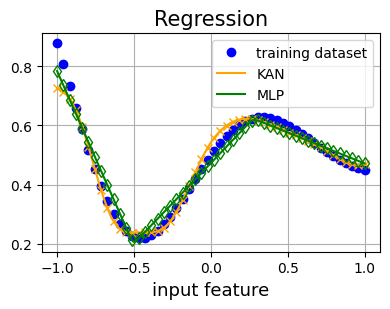

In [ ]:
import numpy as np
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
import matplotlib.pyplot as plt
from utils.activations import tanh_act, relu
from utils.edge_fun import get_bsplines

folder_fig = './'

color_plots = {'dataset': 'b',
               'kan': 'orange',
               'mlp': 'green'}


x_train = np.linspace(-1, 1, 50).reshape(-1, 1)
y_train = .5 * np.sin(4 * x_train) * np.exp(-(x_train+1)) + .5  # sinusoide amortiguada

# Parametros de entrenamiento
n_iter_train_1d = 500
loss_tol_1d = .05
seed = 476

# Entrenamiento con KAN
kan_1d = FeedForward([1, 2, 2, 1],  # Tamaño de la capa
                  eps=.01,  # parámetro de descenso de gradiente
                  n_weights_per_edge=7,  # n. funciones borde
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # límites del dominio de entrada
                  get_edge_fun=get_bsplines,  # Función de borde tipo (B-splines de Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train,
          y_train,
          n_iter_max=n_iter_train_1d,
          loss_tol=loss_tol_1d)

# Entrenamiento con MLP
mlp_1d = FeedForward([1, 13, 1],  # Tamaño de la capa
                  eps=.005,  # parámetro de descenso de gradiente
                  activation=relu,  # tipo de activación (ReLU, tanh o sigmoidal)
                  neuron_class=NeuronNN,
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train,
             y_train,
             n_iter_max=n_iter_train_1d,
             loss_tol=loss_tol_1d)



# Grafico para los resultados:
fig, ax = plt.subplots(figsize=(4,3.2))
x_plot = np.linspace(x_train[0], x_train[-1], 1000).reshape(-1, 1)
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'], label='training dataset')
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color=color_plots['kan'], label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color=color_plots['kan'], fillstyle='none')
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color=color_plots['mlp'], label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color=color_plots['mlp'], fillstyle='none')
ax.set_xlabel('input feature', fontsize=13)
ax.set_title('Regression', fontsize=15)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Ahora se aplica KAN y MLP con un problema de regresión 2D para notar la diferencia de como interactúa cada uno con los datos de entrada:

100%|██████████| 500/500 [00:06<00:00, 72.01it/s, loss: 0.349]


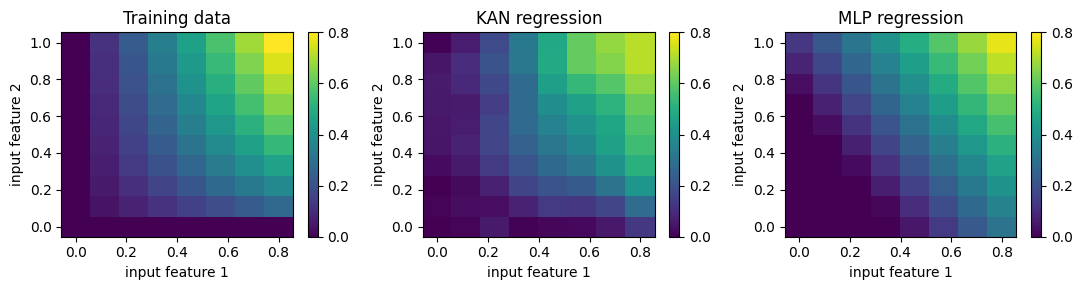

In [ ]:
def fun2d(X1, X2):
    return X1 * np.power(X2, .5)

X1, X2 = np.meshgrid(np.linspace(0, .8, 8), np.linspace(0, 1, 10))
Y_training = fun2d(X1, X2)

x_train2d = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)
y_train2d = Y_training.reshape(-1, 1)

# Parametros para el entrenamiento
n_iter_train_2d = 500
loss_tol_2d = .1
seed = 476

# Entrenamiento con KAN
kan_2d = FeedForward([2, 2, 1],  # layer size
                  eps=.02,  # gradient descent parameter
                  n_weights_per_edge=10,  # n. edge functions
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_2d.train(x_train2d,
          y_train2d,
          n_iter_max=n_iter_train_2d,
          loss_tol=loss_tol_2d)


# Entrenamiento con MLP
mlp_2d = FeedForward([2, 6, 1],  # layer size
                     eps=.0025,  # gradient descend parameter
                     activation=relu,  # activation type (ReLU, tanh or sigmoid)
                     neuron_class=NeuronNN,
                     seed=seed,
                     weights_range=[-.1, .1])
mlp_2d.train(x_train2d,
             y_train2d,
             n_iter_max=n_iter_train_2d,
             loss_tol=loss_tol_2d)


# A contiunuación se grafica:

Y_kan = np.array([kan_2d(xx) for xx in x_train2d])
Y_mlp = np.array([mlp_2d(xx) for xx in x_train2d])

f, a = plt.subplots(1, 3, figsize=(11,3))

vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

im0 = a[0].pcolor(X1, X2, Y_training, vmin=vmin, vmax=vmax)
f.colorbar(im0, ax=a[0])
a[0].set_title('Training data')
a[0].set_xlabel('input feature 1')
a[0].set_ylabel('input feature 2')

im1 = a[1].pcolor(X1, X2, Y_kan.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im1, ax=a[1])
a[1].set_title('KAN regression')
a[1].set_xlabel('input feature 1')
a[1].set_ylabel('input feature 2')

im2 = a[2].pcolor(X1, X2, Y_mlp.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im2, ax=a[2])
a[2].set_title('MLP regression')
a[2].set_xlabel('input feature 1')
a[2].set_ylabel('input feature 2')

f.tight_layout()
plt.show()
# f.savefig(folder_fig + 'regr2D.png', dpi=500)

Por ultimo, se ocupa KAN y MLP para un problema de clasificación usando el dataset "make_moons" de la librería scikit-learnmarks que corresponde a una media luna tal y como se muestra a continuación:

100%|██████████| 1000/1000 [00:21<00:00, 47.61it/s, loss: 6.440]


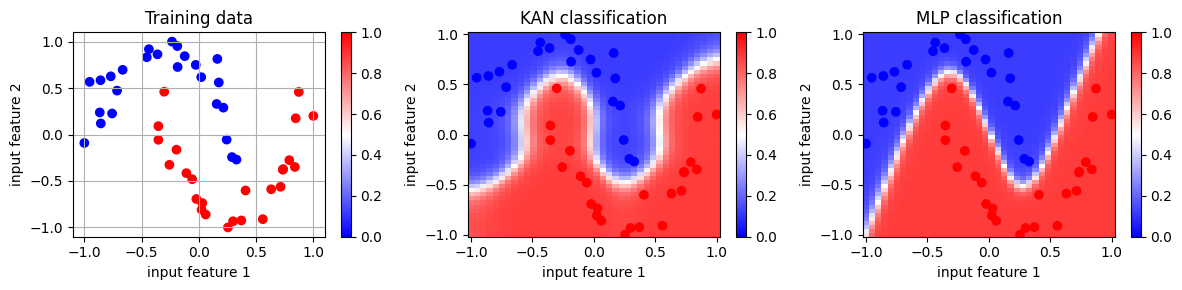

In [ ]:
from sklearn import datasets
from loss.cross_entropy_loss import CrossEntropyLoss

n_samples = 50
noise = 0.1
x_train_cl, y_train_cl = datasets.make_moons(n_samples=n_samples, noise=noise)
# normalize between -1 and 1
x_train_cl[:, 0] = (x_train_cl[:, 0] - min(x_train_cl[:, 0])) / max(x_train_cl[:, 0] - min(x_train_cl[:, 0])) * 2 - 1
x_train_cl[:, 1] = (x_train_cl[:, 1] - min(x_train_cl[:, 1])) / max(x_train_cl[:, 1] - min(x_train_cl[:, 1])) * 2 - 1


# Parametros de entrenamiento
n_iter_train_cl = int(1e3)
loss_tol_cl = 1.5
seed = 476

# Entrenamiento con KAN
kan_cl = FeedForward([2, 2],  # layer size
                     eps=.02,  # gradient descent parameter
                     n_weights_per_edge=8,  # n. edge functions
                     neuron_class=NeuronKAN,
                     loss=CrossEntropyLoss,
                     x_bounds=[-1, 1],  # input domain bounds
                     get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                     seed=seed,
                     weights_range=[-1, 1])
kan_cl.train(x_train_cl,
             y_train_cl.reshape(-1, 1),
             n_iter_max=n_iter_train_cl,
             loss_tol=loss_tol_cl)


# Entrenamiento con MLP
mlp_cl = FeedForward([2, 10, 10, 2],  # layer size
                     eps=.01,  # gradient descend parameter
                     activation=tanh_act,  # activation type (relu, tanh_act or sigmoid_act)
                     neuron_class=NeuronNN,
                     loss=CrossEntropyLoss,
                     seed=seed,
                     weights_range=[-1, 1])
mlp_cl.train(x_train_cl,
             y_train_cl.reshape(-1, 1),
             n_iter_max=n_iter_train_cl,
             loss_tol=loss_tol_cl)

# Grafico de los resultados:

def softmax(vec):
    return np.exp(vec) / sum(np.exp(vec))

X1_cl, X2_cl = np.meshgrid(np.linspace(-1, 1, 40), np.linspace(-1, 1, 50))
x_cl = np.concatenate((X1_cl.reshape(-1, 1), X2_cl.reshape(-1, 1)), axis=1)

Y_kan_cl = np.array([softmax(kan_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)
Y_mlp_cl = np.array([softmax(mlp_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)

fig_cl, ax_cl = plt.subplots(1, 3, figsize=(12,3))
# vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

ax_cl[0].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[0].grid()
ax_cl[0].set_title('Training data')
ax_cl[0].set_xlabel('input feature 1')
ax_cl[0].set_ylabel('input feature 2')

im0 = ax_cl[1].pcolor(X1_cl, X2_cl, Y_kan_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[1].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[1].set_title('KAN classification')
ax_cl[1].set_xlabel('input feature 1')
ax_cl[1].set_ylabel('input feature 2')

im1 = ax_cl[2].pcolor(X1_cl, X2_cl, Y_mlp_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[2].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[2].set_title('MLP classification')
ax_cl[2].set_xlabel('input feature 1')
ax_cl[2].set_ylabel('input feature 2')

fig_cl.colorbar(im1, ax=ax_cl[0])
fig_cl.colorbar(im1, ax=ax_cl[1])
fig_cl.colorbar(im1, ax=ax_cl[2])
fig_cl.tight_layout()
plt.show()

---

# Pregunta 2


## Obtenga resultados de ejecución de las ANN como en el tutorial. En el punto 5 del tutorial, modifique los datos de entrada usando otros datasets y vuelva a hacer comparaciones entre los resultados obtenidos de las distintas redes usadas en el tutorial

A continuación se tiene el código de python de la parte 1 modificado para analizar otro dataset distinto. Además, el eje X tomado corresponderá a la edad normalizada de las personas y el eje Y corresponde a las horas por semanas trabajadas que también fueron normalizadas.

100%|██████████| 500/500 [02:15<00:00,  3.69it/s, loss: 442.000]


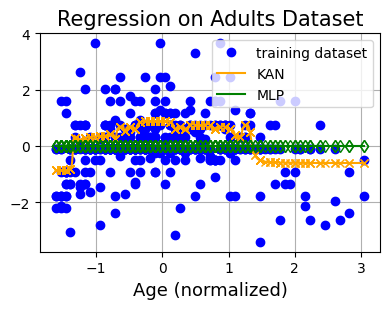

In [ ]:
import numpy as np
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
import matplotlib.pyplot as plt
from utils.activations import relu
from utils.edge_fun import get_bsplines

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv('./adult.data', header=None, names=columns, skipinitialspace=True)

x = data[['age']].values  # Usar 'age' como característica
y = data[['hours-per-week']].values  # Usar 'hours-per-week' como objetivo

x_train, _, y_train, _ = train_test_split(x, y, train_size=442, random_state=42)

# Estandarizar los datos
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)

color_plots = {'dataset': 'b', 'kan': 'orange', 'mlp': 'green'}

n_iter_train_1d = 500
loss_tol_1d = 0.05
seed = 476

# KAN training
kan_1d = FeedForward(
    [1, 2, 2, 1],  # layer size
    eps=0.01,  # gradient descent parameter
    n_weights_per_edge=7,  # n. edge functions
    neuron_class=NeuronKAN,
    x_bounds=[-1, 1],  # input domain bounds
    get_edge_fun=get_bsplines,  # edge function type (B-splines)
    seed=seed,
    weights_range=[-1, 1]
)
kan_1d.train(x_train, y_train, n_iter_max=n_iter_train_1d, loss_tol=loss_tol_1d)

# MLP training
mlp_1d = FeedForward(
    [1, 13, 1],  # layer size
    eps=0.005,  # gradient descent parameter
    activation=relu,  # activation type (ReLU)
    neuron_class=NeuronNN,
    seed=seed,
    weights_range=[-0.5, 0.5]
)
mlp_1d.train(x_train, y_train, n_iter_max=n_iter_train_1d, loss_tol=loss_tol_1d)

# Regression on training data
fig, ax = plt.subplots(figsize=(4, 3.2))
x_plot = np.linspace(x_train.min(), x_train.max(), 1000).reshape(-1, 1)
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'], label='training dataset')
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color=color_plots['kan'], label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color=color_plots['kan'], fillstyle='none')
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color=color_plots['mlp'], label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color=color_plots['mlp'], fillstyle='none')
ax.set_xlabel('Age (normalized)', fontsize=13)
ax.set_title('Regression on Adults Dataset', fontsize=15)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()


### Analisis y comparación de resultados

Para el primer dataset (del tutorial), se observa que era más estructurado y presentaba una relación más clara entre las variables (como las entradas y salidas continuas). Esto indicaba menor ruido y variabilidad, permitiendo un ajuste más estable. En el caso de KAN, este modelo funcionó correctamente, generando patrones no lineales y curvas de ajuste complejas pero precisas, gracias a la menor cantidad de ruido en los datos, lo que permitió que el modelo mostrara su capacidad de aproximación. Sin embargo, para el dataset Adults, que presentaba una mayor cantidad de ruido y dispersión en los datos, KAN mostró una gran sensibilidad al ruido, lo que resultó en sobreajustes en áreas específicas, reduciendo la consistencia de su desempeño.

Por otro lado, MLP mostró un ajuste más general y menos detallado, pero fue capaz de reflejar correctamente la tendencia del dataset del tutorial, mostrando robustez frente a pequeñas variaciones. Para el dataset Adults, MLP mantuvo esta robustez, adaptándose mejor al ruido que KAN, aunque en puntos específicos fue menos preciso. Esto evidencia que KAN sobresale en datasets estructurados y con patrones claros, pero su sensibilidad al ruido limita su desempeño en datasets dispersos como el de Adults. En cambio, MLP ofrece un desempeño estable en ambos escenarios, sacrificando algo de precisión en datasets muy estructurados a cambio de una mejor adaptación al ruido en datos dispersos.

**Respecto a la convergencia de ambos datasets:**

A continuación, se tiene una tabla con el Loss en cada caso:

<table>
  <tr>
    <th> Dataset </th>
    <th>MLP </th>
    <th>KAN </th>

  </tr>
  <tr>
    <td>Tutorial</td>
    <td>0.049</td>
    <td>0.050</td>

    
  </tr>
   <tr>
    <td>Nuevo (Adult)</td>
    <td>394.862</td>
    <td>442.000</td>


  </tr>


  
</table>

El loss es mayor en el dataset Adults producto del ruido y la gran dispersión de los datos, lo que dificulta el ajuste preciso en el modelo. Por otro lado, distinto es en el tutorial cuyas relaciones son claras y definidas, lo que permite una menor pérdida. El modelo no converge en el dataset de Adults debido a esto, generando errores inconsistentes y dificultando encontrar un mínimo local en la función de pérdida, a diferencia del tutorial que converge producto de su estructura clara.

**Conclusión que se puede extraer del gráfico**

Como el gráfico representa las horas trabajadas en función de la edad de las personas, se puede notar gracias a KAN que la mayoría de los datos son cercanos al cero, es decir, que para este conjunto de datos, las personas más jovenes tienden a tener más horas trabajadas por semana.

---

# Pregunta 3





## Explique en sus propias palabras cómo está construida la arquitectura KAN y por qué funciona. Además, haga un análisis sobre los resultados obtenidos y cómo y por qué podrían variar.

### Arquitectura KAN

La arquitectura KAN se basa en el Teorema de representación de Kolmogorov-Arnold y establece que cualquier función continua multivariable puede descomponerse en una suma de funciones más simples de una sola variable.

### Funcionamiento de una KAN

KAN organiza su estructura en tres componentes principales para mapear la entrada **X** = {x_1, x_2, ..., x_n} a una salida **Y** *(ó vector de salidas)*. Para ello, se sigue lo siguiente:

1. **Transformación Lineal de las Entradas:** Cada entrada de la red **x_n** se combina de manera lineal con las otras entradas para generar un conjunto de proyecciones **y_i** tal y como se muestra en la siguiente figura:


![y_i = ∑j=1,n; aij * xj + bi](https://drive.google.com/uc?id=1uflEZkM7mipEZ61kkmK-dZnJ2Qz31RXq)





donde **a_ij y b_i** corresponden a parámetros de la red que se ajustan en el proceso de entrenamiento.

2. **Aplicación de Funciones No Lineales:** Después de la transformación lineal, cada proyección **y_i** pasa por una función de activación (como ReLU, sigmoide, tanh, etc.), quedando como: **𝜙(y_i)**


3. **Combinación de las Salidas No Lineales:** Por ultimo, Las salidas de las funciones no lineales se combinan nuevamente en una sumatoria para obtener la salida final de la red KAN tal y como se muestra en la siguiente figura:

![f(x) = ∑i=1,m; ci * 𝜙(y_i)](https://drive.google.com/uc?id=1tEsoCFD2jrjDMr3LQrAO1AAjLbmBmXWi)


donde **c_i** son los coeficientes de ponderación aprendidos en el proceso de entrenamiento.

### Efectividad:

La efectividad están dadas por los siguientes puntos:

1. **Interpretabilidad**: KAN descompone problemas multivariables en componentes univariados, lo que puede facilitar la interpretación de la red generada.

2. **Flexibilidad:** La red KAN es capaz de representar cualquier función continua sin necesidad de capas profundas ya que puede modelar funciones complejas con pocas capas (en comparación con otros algoritmos) lo que la hace más eficiente.

3. **Limitación:** La red KAN Aunque es potente para funciones continuas, su desempeño es menos efectivo con datos discontinuos o ruidosos (ya que los datos ruidosos tambien producen discontinuidad y variaciones rápidas) lo cual hace que el modelo se sobre ajuste (Overfitting).



### Análisis de resultados obtenidos:



KAN mostró un ajuste más preciso y detallado en el dataset del tutorial, gracias a la claridad en las relaciones no lineales de los datos, generando predicciones confiables y sin signos significativos de sobreajuste. Sin embargo, en el dataset Adults, KAN demostró una alta sensibilidad al ruido, lo que resultó en sobreajustes en áreas con mayor dispersión de los datos. Esta mayor dispersión y el ruido dificultaron el ajuste, provocando que KAN intentara modelar relaciones específicas, lo que afectó su precisión general.

La flexibilidad de KAN le permite capturar patrones complejos, pero también lo hace propenso a ajustarse al ruido. En datasets con patrones menos definidos, como Adults, esto se vuelve más notorio, resultando en sobreajuste y una pérdida significativa de precisión en predicciones futuras. Por lo tanto, aunque KAN es una herramienta poderosa para datos estructurados, su desempeño se ve limitado en escenarios donde los datos son más ruidosos o dispersos.

---

# Referencias:

Manuel. (2024, 27 mayo). What are KAN: Kolmogorov–Arnold Networks? | Medium. Medium. https://medium.com/@manuelescobar-dev/what-are-kan-kolmogorov-arnold-networks-96f261a26eba

A from-scratch implementation of Kolmogorov-Arnold Networks (KAN). . .and MLP. (2024, 15 mayo). ML Without Tears. https://mlwithouttears.com/2024/05/15/a-from-scratch-implementation-of-kolmogorov-arnold-networks-kan/